  0%|          | 0/20 [00:00<?, ?it/s]

tensor(2.0111)
tensor(1.0027)
tensor(-0.3534)
tensor(-2.2042)
tensor(-4.6959)
tensor(-7.9026)
tensor(-11.9291)
tensor(-16.8772)
tensor(-22.8419)
tensor(-29.9088)
tensor(-38.1996)
tensor(-47.8263)
tensor(-58.8850)
tensor(-71.4912)
tensor(-85.7707)
tensor(-101.8778)
tensor(-119.9338)
tensor(-140.0650)
tensor(-162.4410)
tensor(-187.2261)


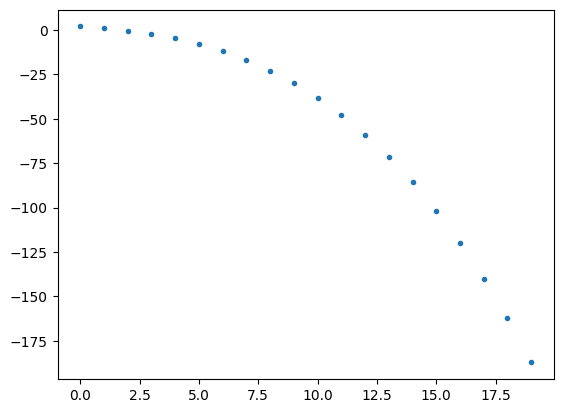

In [32]:
import torch
from sparsemax import Sparsemax
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

class classifier(torch.nn.Module):
    def __init__(self):
        super(classifier, self).__init__()
        self.last_scores = None
        self.last_weights = None

        self.scoring_linear1 = torch.nn.Linear(768, 512)
        self.scoring_linear2 = torch.nn.Linear(512, 128)
        self.scoring_linear3 = torch.nn.Linear(128, 1)
        
        self.relu = torch.nn.LeakyReLU(inplace = False)
        self.sparsemax = Sparsemax(dim = 0)

        self.classifying_linear1 = torch.nn.Linear(768, 512)
        self.classifying_linear2 = torch.nn.Linear(512, 128)
        self.classifying_linear3 = torch.nn.Linear(128, 1)

    def forward(self, x):
        self.last_scores = self.scoring_linear3(
            self.relu(self.scoring_linear2(
            self.relu(self.scoring_linear1(x))
            ))
        )

        # There appears to be a bug with the Sparsemax function.
        # Sparsemax only handles 2-dim tensors, therefore there is a code
        # that does:
        # input = input.transpose(0, self.dim)
        # which means if I have dim = 0, no transpose will happen, therefore I
        # need to transpose the scores first and transpose it back.
        self.last_weights = self.sparsemax(self.last_scores.T).T
        agg_out = torch.sum(self.last_weights * x, dim = 0, keepdim = True)

        result = self.classifying_linear3(
            self.relu(self.classifying_linear2(
            self.relu(self.classifying_linear1(agg_out))
            ))
        )
        return result

df_pos = pd.read_parquet("dcr_alpha_LTX051_LN1_M13_a-LTX051_LN1_M13_b.parquet")
df_neg = pd.read_parquet("dcr_HCW_0003_6M_1_alpha.parquet")
embeddings_pos = torch.from_numpy(df_pos.values).to(torch.float32)
embeddings_neg = torch.from_numpy(df_neg.values).to(torch.float32)
model = classifier()
criterion = torch.nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)

pos_trainloss = []
neg_trainloss = []
train_loss = []

for i in tqdm(range(20)):
    ypred = model(embeddings_pos)
    loss_pos = criterion(torch.ones((1, 1)), ypred)
    pos_trainloss.append(loss_pos.data.tolist())

    y_pred = model(embeddings_neg)
    loss_neg = criterion(torch.zeros((1, 1)), ypred)
    neg_trainloss.append(loss_pos.data.tolist())


    loss = loss_pos + loss_neg
    print (loss.data)
    train_loss.append(loss.data.tolist())

    optim.zero_grad()
    loss.backward()
    optim.step()

plt.scatter([i for i in range(len(train_loss))], train_loss, marker = ".")
plt.show()

In [33]:
model.last_weights

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], grad_fn=<PermuteBackward0>)